# LSTM

In [2]:
import numpy as np
import pandas as pd 
import re
import helper
import random
import string
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

import pdb

import time
import math

In [3]:
# Run this to reload helper.py so you don't have to restart the kernel
import importlib

importlib.reload(helper)

<module 'helper' from '/Users/glchau/Desktop/Caltech/CS155/loan-sharks/poems/helper.py'>

## Preprocess data

In [4]:
all_words, all_sequences, word_dict, all_sonnet_int = helper.getAllWordsAndSequences("data/shakespeare.txt", "data/Syllable_dictionary.txt")

## Variables and helper functions for RNN training 

In [5]:
all_character_sequences = [' '.join(seq[:-1]) for seq in all_sequences]
all_character_sequences_no_empty = [seq for seq in all_character_sequences if len(seq) > 0]


In [6]:
fixed_length_character_sequences_valid_start = [] 
big_string = ' '.join(all_character_sequences_no_empty)
big_string = ' ' + big_string
step_size = 5
for i in range(0, len(big_string)):
    if (big_string[i-1] == ' ') and (big_string[i] != ' '):
        if len(big_string[i:i+40]) == 40: 
            fixed_length_character_sequences_valid_start.append(big_string[i:i+40])        

In [7]:
len(fixed_length_character_sequences_valid_start)

17566

In [8]:
all_letters = string.ascii_lowercase + " '-"  # abcdefghijklmnopqrstuvwxyz '-
n_letters = len(all_letters) + 1 # Plus EOS marker
all_categories = [0] # Only have 1 category for now. We could try to categorize lines by position or ending rhyme
n_categories = len(all_categories)

lens = [len(seq) for seq in fixed_length_character_sequences_valid_start]
max_length = max(lens)
min_lenth = min(lens)
max_length

40

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [10]:
def inputTensor(line):
    # One-hot matrix of first to last letters (not including EOS) for input
    # tensor = torch.zeros(len(line), n_letters)
    # for li in range(len(line)):
    #     letter = line[li]
    #     tensor[li][all_letters.find(letter)] = 1
    
    # Indices 
    letter_indexes = [all_letters.find(line[li]) for li in range(0, len(line))]
    return torch.LongTensor(letter_indexes) #tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

def inputTargetLists(line): 
    inputList = [all_letters.find(line[li]) for li in range(0, len(line))]
    targetList = [all_letters.find(line[li]) for li in range(1, len(line))]
    targetList.append(n_letters - 1)
    return inputList, targetList

In [11]:
# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Generate a batch of lines with input and target tensors 
def randomBatch(category_lines, batch_size=16):
    input_tensors = []
    target_tensors = []
    for b in range(batch_size): 
        line = randomChoice(category_lines)
        inputList, targetList = inputTargetLists(line)
        
        input_tensors.append(inputList)
        target_tensors.append(targetList)
    return torch.LongTensor(input_tensors), torch.LongTensor(target_tensors)

### Training Functions

In [12]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [13]:
# train the RNN on the input and target batch values 

def train_batch(rnn, input_line_tensor, target_line_tensor, optimizer, criterion):
    
    # Put in extra dimension for the "Layer" dimension of LSTM inputs 
    input_line_tensor = torch.unsqueeze(input_line_tensor, dim=0)
    target_line_tensor = torch.unsqueeze(target_line_tensor, dim=0)
    
    # Initilize the hidden and cell matrices 
    hidden, cell = rnn.initHidden()

    # Zero out the gradients for each batch
    rnn.zero_grad()

    # Initlize loss to 0
    loss = 0

    # Iterate through all 40 characters in the sequence
    for i in range(input_line_tensor.size(2)):
        
        # Select only the ith character for the batch
        input_tensor = input_line_tensor[:, :, i] 
        target_tensor = target_line_tensor[:, :, i] 
        
        # Forward pass through RNN 
        output, (hidden, cell) = rnn(input_tensor, (hidden, cell))
        
        # Loss calculation
        l = criterion(torch.squeeze(output, dim=0), torch.squeeze(target_tensor, dim=0))
        loss += l.item() / rnn.batch_size

        # Compute gradients and take optimizer step
        optimizer.zero_grad()
        l.backward(retain_graph=True)
        optimizer.step()

    return loss / input_line_tensor.size(0)

In [14]:
# Sample from a category and starting letter

def sample(rnn, start_letter='A', length=max_length, temperature=1):
    with torch.no_grad():  # no need to track history in sampling
        rnn.eval()
        inputs = inputTensor(start_letter).to(device)
        hidden, cell = torch.zeros(1, 1, rnn.hidden_size).to(device), torch.zeros(1, 1, rnn.hidden_size).to(device)

        output_name = start_letter

        for i in range(length):
            inputs = inputs[None, :]
            
            output, (hidden, cell) = rnn(inputs, (hidden, cell), temperature=temperature)
            
            topi = torch.multinomial(output.data[0], 1)
            # pdb.set_trace()
            # topv, topi = output.topk(1)
            topi = topi[0][0]
            
            # Last index is <EOS> so we just kill the appending
            if topi == n_letters - 1:
                break 
            else:
                letter = all_letters[topi]
                output_name += letter
            
            inputs = inputTensor(letter).to(device)

        return output_name

## One Hot encoding LSTM

In [18]:


class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_classes, batch_size, device, n_layers=1): # n_classes is output_size 
        super(RNN, self).__init__()
        self.input_size = input_size # input size is number of classes in our case 
        self.hidden_size = hidden_size # hidden layer size 
        self.n_classes = n_classes # number of classes 
        self.batch_size = batch_size # size of batch
        self.n_layers = n_layers # number of layers in LSTM
        self.device = device # 'cuda' or 'cpu'
        

        # self.embedding = nn.Embedding(input_size, input_size)
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=1)
        self.decoder = nn.Linear(hidden_size, n_classes)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.Softmax(dim=2)
        

    def forward(self, input_vals, hc, temperature=1):
        # embeding = self.embedding(input_vals)
        one_hot = torch.nn.functional.one_hot(input_vals, num_classes=self.n_classes)
        # pdb.set_trace()
        output, hc = self.lstm(one_hot.float(), hc)
        output = self.decoder(output)
        output = self.dropout(output)
        # pdb.set_trace()
        output = self.softmax(output / temperature)
        return output, (hc[0].detach(), hc[1].detach())

    def initHidden(self, num_layers=None, batch_size=None, hidden_size=None):
        if num_layers is None:
            num_layers = self.n_layers
        if batch_size is None:
            batch_size = self.batch_size
        if hidden_size is None:
            hidden_size = self.hidden_size
            
        return torch.zeros(num_layers, batch_size, hidden_size).to(self.device), torch.zeros(num_layers, batch_size, hidden_size).to(self.device)

In [15]:
######### PARAMETERS #########
batch_size = 32
hidden_size = 800
n_iters = 5000
print_every = 100
plot_every = 500
learning_rate = 0.0005
############################## 

rnn = RNN(n_letters, hidden_size, n_letters, device=device, batch_size=batch_size).to(device) # expand hidden units 

criterion = nn.CrossEntropyLoss() 

optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters + 1):
    try : 
        input_line_tensor, target_line_tensor = randomBatch(fixed_length_character_sequences_valid_start, batch_size=batch_size)
        loss = train_batch(rnn, input_line_tensor.to(device), target_line_tensor.to(device), criterion=criterion, optimizer=optimizer)
        total_loss += loss
    except : 
        print(input_line_tensor)
        raise

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 10s (100 2%) 4.1051
0m 20s (200 4%) 4.0950
0m 30s (300 6%) 4.0984
0m 38s (400 8%) 4.1100
0m 47s (500 10%) 4.1104
0m 56s (600 12%) 4.0978
1m 4s (700 14%) 4.1100
1m 14s (800 16%) 4.1140
1m 22s (900 18%) 4.0927
1m 31s (1000 20%) 4.1001
1m 39s (1100 22%) 4.1121
1m 48s (1200 24%) 4.0957
1m 57s (1300 26%) 4.1116
2m 5s (1400 28%) 4.0888
2m 14s (1500 30%) 4.1006
2m 23s (1600 32%) 4.1015
2m 31s (1700 34%) 4.1007
2m 40s (1800 36%) 4.1186
2m 48s (1900 38%) 4.1052
2m 57s (2000 40%) 4.0902
3m 5s (2100 42%) 4.0997
3m 14s (2200 44%) 4.1011
3m 22s (2300 46%) 4.1125
3m 31s (2400 48%) 4.1016
3m 39s (2500 50%) 4.0959
3m 48s (2600 52%) 4.0956
3m 56s (2700 54%) 4.1060
4m 5s (2800 56%) 4.1014
4m 13s (2900 57%) 4.0907
4m 22s (3000 60%) 4.1050
4m 31s (3100 62%) 4.1025
4m 39s (3200 64%) 4.1035
4m 48s (3300 66%) 4.0994
4m 56s (3400 68%) 4.1059
5m 5s (3500 70%) 4.0858
5m 13s (3600 72%) 4.1052
5m 22s (3700 74%) 4.1064
5m 30s (3800 76%) 4.1027
5m 39s (3900 78%) 4.1006
5m 47s (4000 80%) 4.0942
5m 56s (4100 82%) 

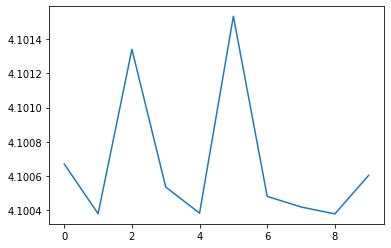

In [16]:
plt.plot(all_losses)

In [20]:
sample(rnn, 'e', length=20, temperature=1)

'e                                        '

## Embedding LSTM

In [15]:
class RNN_Embedding(nn.Module):
    def __init__(self, input_size, hidden_size, n_classes, device, batch_size, n_layers=1): # n_classes is output_size 
        super(RNN_Embedding, self).__init__()
        self.input_size = input_size # input size is number of classes in our case 
        self.hidden_size = hidden_size # hidden layer size 
        self.n_classes = n_classes # number of classes 
        self.batch_size = batch_size # size of batch
        self.n_layers = n_layers # number of layers in LSTM
        self.device = device # 'cuda' or 'cpu'

        self.embedding = nn.Embedding(input_size, input_size)
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=n_layers)
        self.fc1 = nn.Linear(hidden_size, 128)
        self.fc2 = nn.Linear(128, n_classes)
        self.relu = nn.LeakyReLU(negative_slope=0.01)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.Softmax(dim=2)
        

    def forward(self, input_vals, hc, temperature=1):
        embedding = self.embedding(input_vals)
        # pdb.set_trace()
        output, hc = self.lstm(embedding, hc)
        output = self.fc1(output)
        output = self.fc2(output)
        output = self.relu(output)
        output = self.dropout(output)
        # pdb.set_trace()
        output = self.softmax(output / temperature)
        return output, (hc[0].detach(), hc[1].detach())

    def initHidden(self, num_layers=None, batch_size=None, hidden_size=None):
        if num_layers is None:
            num_layers = self.n_layers
        if batch_size is None:
            batch_size = self.batch_size
        if hidden_size is None:
            hidden_size = self.hidden_size
            
        return torch.zeros(num_layers, batch_size, hidden_size).to(device), torch.zeros(num_layers, batch_size, hidden_size).to(device)

In [16]:
######### PARAMETERS #########
batch_size = 32
hidden_size = 800
n_iters = 5000
print_every = 100
plot_every = 500
learning_rate = 0.0005
############################## 

rnn_embedding = RNN_Embedding(input_size=n_letters, hidden_size=hidden_size, n_classes=n_letters, n_layers=1, device=device, batch_size=batch_size).to(device) # expand hidden units 

criterion = nn.CrossEntropyLoss() 

optimizer = torch.optim.Adam(rnn_embedding.parameters(), lr=learning_rate)

import pdb

all_losses_embed = []
total_loss_embed = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters + 1):
    try : 
        input_line_tensor, target_line_tensor = randomBatch(fixed_length_character_sequences_valid_start, batch_size=batch_size)
        loss = train_batch(rnn_embedding, input_line_tensor.to(device), target_line_tensor.to(device), criterion=criterion, optimizer=optimizer)
        total_loss_embed += loss
    except : 
        print(input_line_tensor)
        raise

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses_embed.append(total_loss_embed / plot_every)
        total_loss_embed = 0

7m 30s (100 2%) 4.0816
13m 23s (200 4%) 4.0740
19m 31s (300 6%) 4.0911
26m 57s (400 8%) 4.0936
35m 33s (500 10%) 4.0700
42m 5s (600 12%) 3.9891
45m 35s (700 14%) 3.9360
50m 6s (800 16%) 3.9051
54m 45s (900 18%) 3.8929
59m 21s (1000 20%) 3.8842
63m 26s (1100 22%) 3.8740
67m 53s (1200 24%) 3.8605
72m 37s (1300 26%) 3.8747
77m 1s (1400 28%) 3.8628
81m 40s (1500 30%) 3.8490
86m 40s (1600 32%) 3.8221
92m 12s (1700 34%) 3.8076
98m 2s (1800 36%) 3.7995
104m 46s (1900 38%) 3.8266
112m 9s (2000 40%) 3.8196
119m 12s (2100 42%) 3.7926
127m 1s (2200 44%) 3.8161
135m 8s (2300 46%) 3.8166
142m 32s (2400 48%) 3.8110
148m 39s (2500 50%) 3.8046
154m 33s (2600 52%) 3.7783
160m 26s (2700 54%) 3.8135
166m 19s (2800 56%) 3.7476
172m 28s (2900 57%) 3.7421
179m 4s (3000 60%) 3.7855
185m 51s (3100 62%) 3.7838
192m 39s (3200 64%) 3.7766
199m 42s (3300 66%) 3.7758
206m 20s (3400 68%) 3.7903
212m 30s (3500 70%) 3.7903
218m 35s (3600 72%) 3.7885
224m 34s (3700 74%) 3.7707
230m 25s (3800 76%) 3.7671
236m 52s (3900

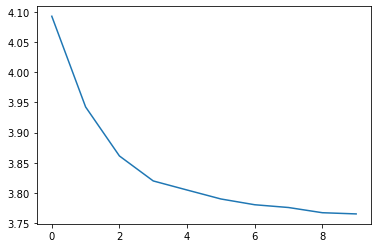

In [17]:
plt.plot(all_losses_embed)

In [23]:
# Sample a poem
for i in range(14): 
    original_sample = sample(rnn_embedding, random.choice(string.ascii_lowercase[:-3]), 
                             length=random.randint(30, 50), temperature=1.5)
    print(' '.join(original_sample.split(" ")[:-1]))
    if i in [3, 7, 11]:
        print()

shoul the starth the stars the
he the starth the starth the
the starth the starth the starth the starth
in the starth the starth the

ever the starth the starth the starth
in the starth the starth the
in the starth the starth the starth the
for the stars the starth the starth the

const the starth the starth the starth
painted the starth the starth the starth the
painted the starth the starth the starth
he the starth the starth the starth the

unted the starth the starth the
unted the starth the starth the


In [21]:
torch.save(rnn_embedding.state_dict(), "./models/lstm_embedding_addLayers_model.pt")
